# Visualizing Dense layer using ActivationMaximization

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/visualize_dense_layer.ipynb)
[![Right click and save](https://img.shields.io/badge/Notebook-Open_In_Github-orange.svg)](https://github.com/keisen/tf-keras-vis/blob/master/docs/examples/visualize_dense_layer.ipynb)


Preparation
-----------

### Load libraries

In [ ]:
!pip install tf-keras-vis

     |████████████████████████████████| 53 kB 1.4 MB/s 


In [ ]:
%reload_ext autoreload
%autoreload 2
 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
 
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
from tf_keras_vis.activation_maximization.callbacks import Progress, PrintLogger
 
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Load tf.keras.Model

In this notebook, we use VGG16 model, however if you want to use other tf.keras.Model, you can do so by modifying the section below.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
 
# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

553476096/553467096 [==============================] - 11s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

## Implement functions required to use ActivationMaximization

### Model modifier

When the softmax activation function is applied to the last layer of model, it may obstruct generating the actiation maps, so you should replace the function to a linear activation function. Here, we create and use `ReplaceToLinear` instance.

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, ExtractIntermediateLayer
 
replace2linear = ReplaceToLinear()
 
# Instead of using ReplaceToLinear instance,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Score function

You **MUST** create `Score` instance or define `score function` that returns arbitrary category value. Here, our socre function returns the value corresponding to No.20 (Ouzel) of imangenet.

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore
 
# 20 is the imagenet index corresponding to Ouzel.
scores = CategoricalScore([2, 22, 413])
seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)
image_titles = ['Great White Shark', 'Bald Eagle', 'Assault Rifle']
 
# Instead of using CategoricalScore object above,
# you can also define the function from scratch as follows:
# def score_function(output):
#     # The `output` variable refer to the output of the model,
#     # so, in this case, `output` shape is `(1, 1000)` i.e., (samples, classes).
#     return output[:, 20]

## Visualizing a specific output category

### Create ActivationMaximization Instnace

When `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, however the process may take a while.

In [ ]:
from tf_keras_vis.activation_maximization import ActivationMaximization
 
activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("predictions"), ReplaceToLinear()],
                                                 clone=True)
# def score_function(output):
#     # The `output` variable refer to the output of the model,
#     # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
#     return (output[:, 407], output[:, 546], output[:, 290])

200/200 [==============================] - 67s 269ms/step - Score: 225.0038 - TotalVariation2D: 17.6767 - Norm: 36.3560


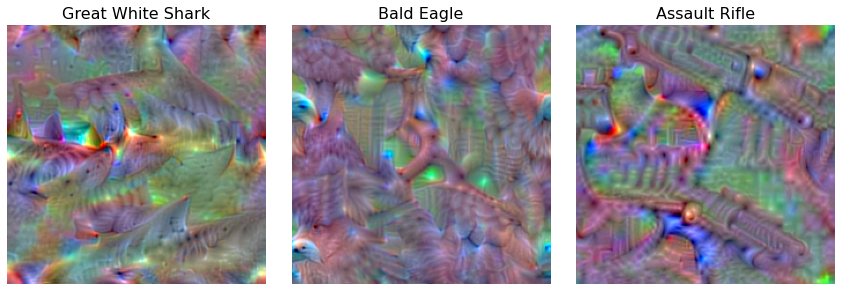

CPU times: user 46.6 s, sys: 1.99 s, total: 48.6 s
Wall time: 1min 8s


In [ ]:
# original
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=replace2linear,
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

### Visualize

ActivationMaximization will maximize the output of the score function. Here, as a result, we will get a visualized image that maximizes the model output corresponding to the No.20 (Ouzel) of imagenet.

200/200 [==============================] - 53s 266ms/step - Score: 1033.5682 - TotalVariation2D: 22.3061 - Norm: 39.4690


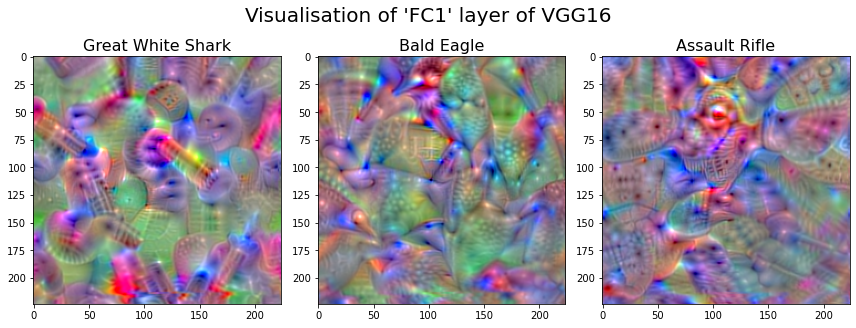

CPU times: user 42.4 s, sys: 1 s, total: 43.4 s
Wall time: 55.1 s
Parser   : 334 ms


In [ ]:
# fc1
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("fc1"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
f.suptitle("Visualisation of 'FC1' layer of VGG16", y=1.1, fontsize=20)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('on')
plt.tight_layout()
plt.show()

200/200 [==============================] - 52s 262ms/step - Score: 209.2906 - TotalVariation2D: 18.1652 - Norm: 36.6879


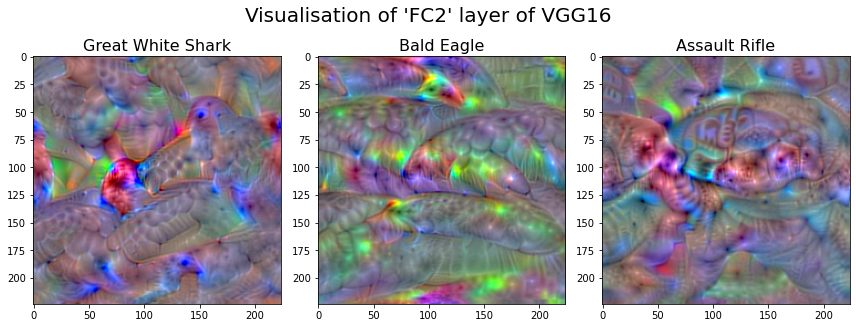

CPU times: user 41.5 s, sys: 826 ms, total: 42.3 s
Wall time: 53.6 s


In [ ]:
# fc2
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("fc2"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
f.suptitle("Visualisation of 'FC2' layer of VGG16", y=1.1, fontsize=20)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('on')
plt.tight_layout()
plt.show()

200/200 [==============================] - 53s 265ms/step - Score: 218.2698 - TotalVariation2D: 18.2746 - Norm: 36.2398


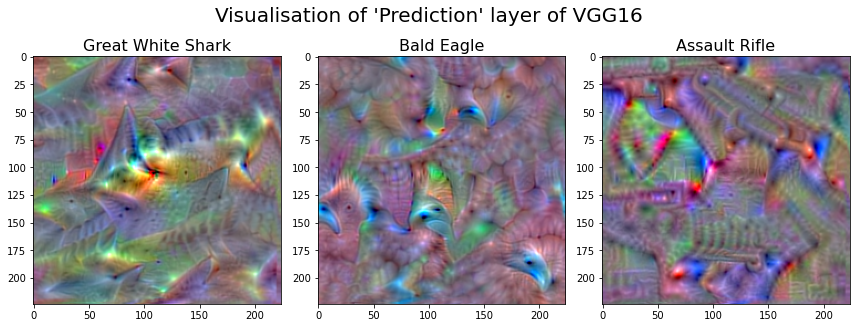

CPU times: user 42.3 s, sys: 882 ms, total: 43.2 s
Wall time: 54.5 s


In [ ]:
# predictions
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("predictions"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
f.suptitle("Visualisation of 'Prediction' layer of VGG16", y=1.1, fontsize=20)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('on')
plt.tight_layout()
plt.show()

200/200 [==============================] - 52s 262ms/step - Score: 987.9561 - TotalVariation2D: 22.7978 - Norm: 40.0685


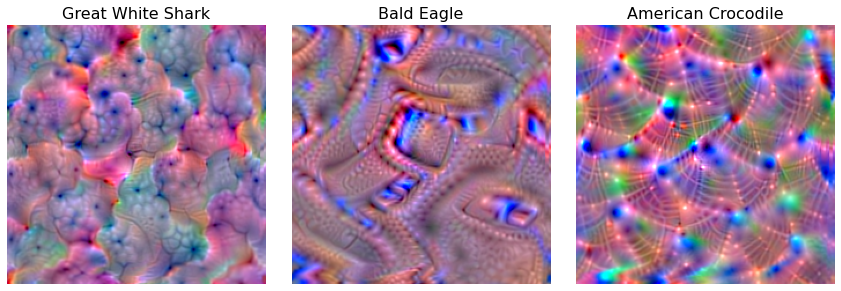

CPU times: user 40.8 s, sys: 960 ms, total: 41.7 s
Wall time: 53.2 s


In [ ]:
# predictions
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("block5_conv3"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

(3, 224, 224, 3)
200/200 [==============================] - 48s 238ms/step - Score: 4397.4282 - TotalVariation2D: 29.3168 - Norm: 42.8137


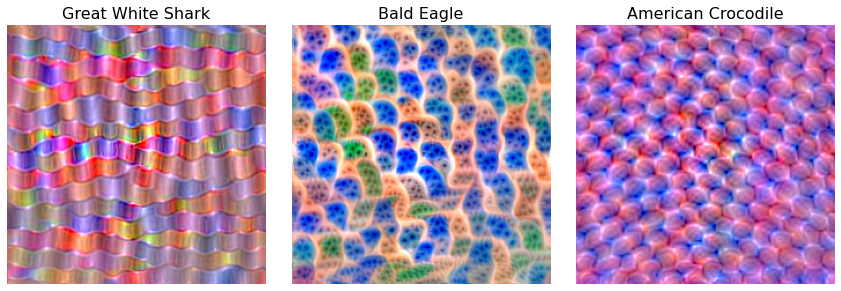

In [ ]:
# block5_conv3
# %%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("block4_conv3"), ReplaceToLinear()],
                                                 clone=True)

print(seed_input.shape)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

200/200 [==============================] - 43s 215ms/step - Score: 5681.8052 - TotalVariation2D: 31.9985 - Norm: 42.3963


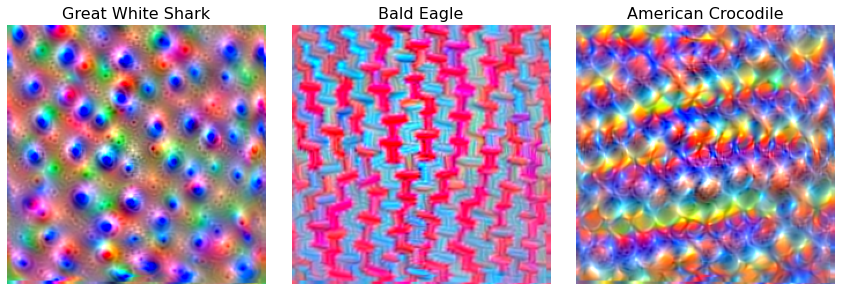

CPU times: user 34.5 s, sys: 752 ms, total: 35.3 s
Wall time: 43.9 s


In [ ]:
# block4_conv2
# last
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("block4_conv2"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

200/200 [==============================] - 29s 146ms/step - Score: 3719.7109 - TotalVariation2D: 36.6200 - Norm: 42.2082


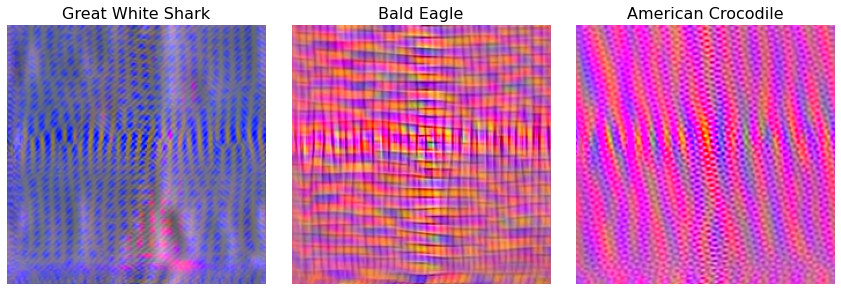

CPU times: user 25 s, sys: 625 ms, total: 25.6 s
Wall time: 30.1 s


In [ ]:
# block3_conv1
# last
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("block3_conv1"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

200/200 [==============================] - 22s 111ms/step - Score: 1331.6815 - TotalVariation2D: 42.8763 - Norm: 50.7402


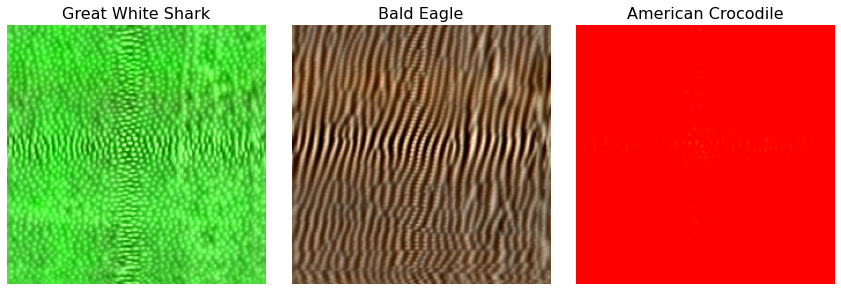

CPU times: user 20.1 s, sys: 552 ms, total: 20.6 s
Wall time: 23.1 s


In [ ]:
# block2_conv1
# last
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("block2_conv1"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

200/200 [==============================] - 12s 61ms/step - Score: 739.8618 - TotalVariation2D: 4.6630 - Norm: 72.3597


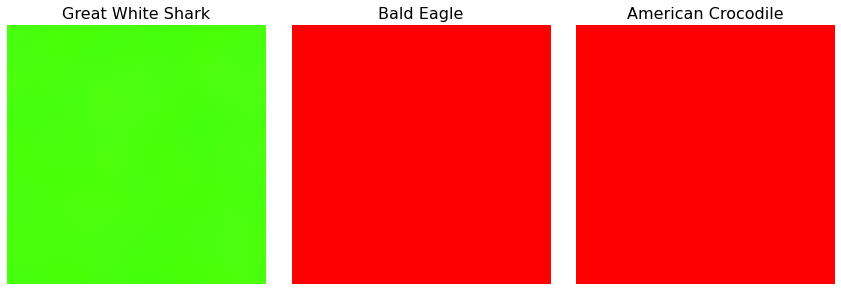

CPU times: user 12.6 s, sys: 476 ms, total: 13 s
Wall time: 13 s


In [ ]:
# block1_conv1
# last
%%time
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D, Scale
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D

activation_maximization = ActivationMaximization(model,
                                                 model_modifier=[ExtractIntermediateLayer("block1_conv1"), ReplaceToLinear()],
                                                 clone=True)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])
 
## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
# f, ax = plt.subplots(figsize=(4, 4))
# ax.imshow(activations[0])
# ax.set_title('Ouzel', fontsize=16)
# ax.axis('off')
# plt.tight_layout()
# plt.show()

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Visualizing specific output categories

Then, let's visualize multiple categories at once!

### Modify Score function

Because change the target you want to visualize, you **MUST** create `Score` instance or define `score function` again that returns arbitrary category values. Here, our socre function returns the values corresponding to No.1 (Goldfish), No.294 (Bear) and No.413 (Assault rifle) of imagenet.

### Create Seed-Input values

And then, you MUST create `seed_input` value. In default, when visualizing a specific output category, tf-keras-vis automatically generates `seed_input` to visualize a image for each model input. When visualizing multiple images, you MUST manually create `seed_input`.

### Visualize